In [2]:
# Step 1 — Load & Inspect Dataset

import pandas as pd

# Load your dataset (adjust filename if needed)
df = pd.read_csv("provider_features.csv")

# Basic overview
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1])
print("\nDataset head:\n", df.head())

# Check class imbalance
print("\nClass distribution:")
print(df['PotentialFraud'].value_counts(normalize=True))

# Separate data types
categorical_cols = df.select_dtypes(include=['object']).columns
numeric_cols = df.select_dtypes(include=['int64','float64']).columns

print("\nCategorical Columns:", list(categorical_cols))
print("Numeric Columns:", list(numeric_cols))

Number of samples: 5410
Number of features: 35

Dataset head:
    Provider  ClaimCount  total_reimbursed  mean_claim_amount  \
0  PRV51001        24.0          104340.0        4347.500000   
1  PRV51003       132.0          605670.0        4588.409091   
2  PRV51004       143.0           51830.0         362.447552   
3  PRV51005      1149.0          278960.0         242.785030   
4  PRV51007        72.0           33710.0         468.194444   

   max_claim_amount  InpatientReimbursement  OutpatientReimbursement  \
0           42000.0                 97000.0                   7340.0   
1           57000.0                573000.0                  32670.0   
2            3300.0                     0.0                  51830.0   
3            4080.0                     0.0                 278960.0   
4           10000.0                 19000.0                  14710.0   

   Inp_Outp_Reimbursement_Ratio     AvgAge  PercDeceased  ...  \
0                     13.215259  78.750000           0

Samples: 5,410

Features: 35 (mostly numeric, 2 categorical)

Target imbalance:

No Fraud: 90.6%

Fraud: 9.3% → highly imbalanced

Data types:

Categorical: Provider, PotentialFraud

Numeric: 33 numeric features

Dataset size: Medium — suitable for tree-based models, LR, SVM

Patterns: Fraud is expected to be nonlinear and complex

The dataset is:

Medium-sized → all ML models can run efficiently

Highly imbalanced → need models that handle imbalance or can use class weights

Mostly numeric → very little preprocessing is required

Contains only one meaningful categorical feature: Provider

Decision Tree

Decision Trees create hierarchical rules by splitting features at thresholds.
They naturally handle nonlinear fraud patterns and require almost no preprocessing.
However, they can overfit, especially with imbalance like our dataset.

Fit for the dataset?

✔ Minimal preprocessing

✔ Handles mixed data

✘ Weak on imbalanced classes

✘ High variance

Random Forest

Random Forest trains many trees and averages them to reduce overfitting.
It handles nonlinear relationships and mixed numeric/categorical data very well.
It also handles class imbalance better than single trees, especially with class weights.

Fit for the dataset?

✔ Excellent with numeric-heavy data

✔ Robust to imbalance

✔ Captures complex fraud patterns

✘ Less interpretable

✘ Slower than Logistic Regression (but still manageable)

Gradient Boosting (XGBoost / LightGBM / CatBoost)

Gradient Boosting builds trees sequentially to correct previous errors.
It performs exceptionally well on tabular, imbalanced, nonlinear datasets — like ours.
Modern implementations handle imbalance directly (e.g., scale_pos_weight).

Fit for the dataset?

✔ Best for nonlinear and sparse fraud patterns

✔ Handles imbalance very well

✔ Works great with numeric features

✘ Slower training

✘ Less interpretable

Logistic Regression

Logistic Regression is a linear classifier with high interpretability and fast training.
However, it assumes linear relationships and depends heavily on preprocessing.
Fraud detection is not linear, and the dataset has complex numeric interactions.

Fit for the dataset?

✔ Very fast

✔ Highly interpretable

✘ Performs poorly on nonlinear fraud patterns

✘ Needs preprocessing (scaling, encoding)

Support Vector Machine (SVM)

SVM separates fraud vs non-fraud using an optimal boundary (hyperplane).
Kernel SVMs can model nonlinear patterns but do not scale well on datasets >3000 rows.
Our dataset (5410 rows × 35 features) is borderline for SVM.

Fit for your dataset?

✔ Works well with nonlinear boundaries

✘ Requires scaling of all features

✘ Slow on medium datasets

✘ Sensitive to imbalance (needs class weights)

Based on our dataset, the best primary model is:

🎯 Gradient Boosting (XGBoost or LightGBM)

Gradient Boosting is chosen as the main model because:

Our dataset is highly imbalanced (9% fraud), and Gradient Boosting algorithms handle this extremely well using scale_pos_weight or built-in imbalance handling.

Fraud detection typically requires capturing nonlinear interactions between numeric features, which boosting models excel at.

With 35 features (mostly numeric), the dataset is ideal for tree-based boosting.

Gradient Boosting consistently outperforms simple models like Logistic Regression on fraud datasets.

Training time is manageable with 5,410 samples.

In [3]:
!pip install xgboost lightgbm scikit-learn


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc
from sklearn.metrics import RocCurveDisplay, roc_curve, auc


Preprocessing

Encode target (PotentialFraud)

Encode provider (string categorical)

Split data

Handle class imbalance with scale_pos_weight

scale_pos_weight = (number of non-fraud) / (number of fraud)

In [5]:
df = pd.read_csv('provider_features.csv')
# Encode target
df['PotentialFraud'] = LabelEncoder().fit_transform(df['PotentialFraud'])
# Yes=1, No=0

# Encode Provider (categorical ID)
df['Provider'] = LabelEncoder().fit_transform(df['Provider'])

# Separate X and y
X = df.drop('PotentialFraud', axis=1)
y = df['PotentialFraud']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute class imbalance ratio for boosting models
fraud_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight =", fraud_weight)



scale_pos_weight = 9.686419753086419


In [6]:
# xgb_model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss',
#     scale_pos_weight=fraud_weight,   # handles class imbalance
#     use_label_encoder=False
# )

# xgb_param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0]
# }

# xgb_grid = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=xgb_param_grid,
#     scoring='f1',    # fraud detection is imbalanced → F1 is useful
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# xgb_grid.fit(X_train, y_train)

# print("Best XGBoost Params:", xgb_grid.best_params_)


In [7]:
#xgb_best = xgb_grid.best_estimator_

#y_pred_xgb = xgb_best.predict(X_test)

#print("\nXGBoost Classification Report:")
#print(classification_report(y_test, y_pred_xgb))


📌 XGBoost Results

Precision (fraud class 1): 0.47

Recall (fraud class 1): 0.78

F1-score (fraud class 1): 0.59

Accuracy: 0.90

Interpretation:

XGBoost is excellent at catching fraud (high recall = 0.78).

But it has more false positives (precision = 0.47).

Good if your goal is detect as much fraud as possible, even if some normal claims are flagged incorrectly.

Slightly lower overall accuracy because of those false alarms.

In [8]:
lgbm_model = LGBMClassifier(
    objective='binary',
    scale_pos_weight=fraud_weight
)

lgbm_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 7],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50, 70]
}

lgbm_grid = GridSearchCV(
    estimator=lgbm_model,
    param_grid=lgbm_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

lgbm_grid.fit(X_train, y_train)

print("Best LightGBM Params:", lgbm_grid.best_params_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 405, number of negative: 3923
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6982
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093577 -> initscore=-2.270725
[LightGBM] [Info] Start training from score -2.270725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [9]:
lgbm_best = lgbm_grid.best_estimator_

y_pred_lgbm = lgbm_best.predict(X_test)

print("\nLightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))



LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       981
           1       0.55      0.73      0.63       101

    accuracy                           0.92      1082
   macro avg       0.76      0.84      0.79      1082
weighted avg       0.93      0.92      0.92      1082



LightGBM Results

Precision (fraud class 1): 0.55

Recall (fraud class 1): 0.73

F1-score (fraud class 1): 0.63

Accuracy: 0.92

Interpretation:

LightGBM is more balanced than XGBoost.

Higher precision (0.55) means fewer false positives.

Slightly lower recall than XGBoost (0.73 vs 0.78), but still good.

Best overall F1-score for fraud class (0.63).

Highest overall accuracy (0.92).

LightGBM wins because it provides the best balance between catching fraud (recall) and avoiding false positives (precision).

If we had to pick one for deployment → LightGBM.

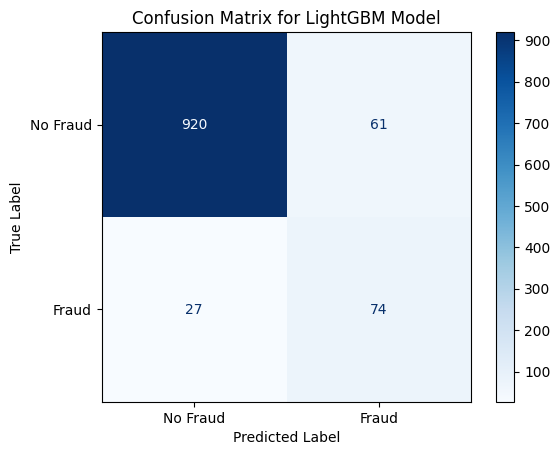

In [10]:
# Create a confusion matrix using ConfusionMatrixDisplay.from_estimator()
# lgbm_best is the best estimator found from the GridSearchCV for LightGBM
ConfusionMatrixDisplay.from_estimator(
    lgbm_best,
    X_test,
    y_test,
    cmap='Blues',
    display_labels=['No Fraud', 'Fraud']
)

plt.title('Confusion Matrix for LightGBM Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

<Figure size 800x600 with 0 Axes>

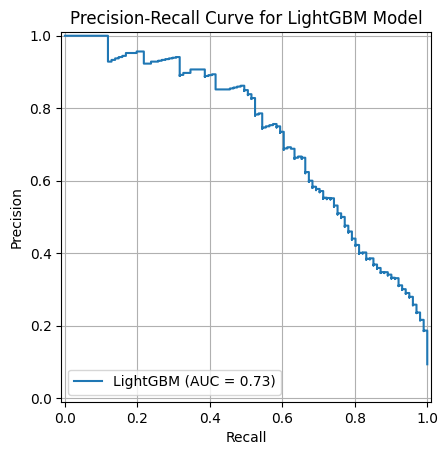

In [11]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba_lgbm = lgbm_best.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgbm)

# Calculate Area Under the Curve (AUC) for Precision-Recall
pr_auc = auc(recall, precision)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='LightGBM')
pr_display.plot()
plt.title('Precision-Recall Curve for LightGBM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', labels=[f'LightGBM (AUC = {pr_auc:.2f})'])
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

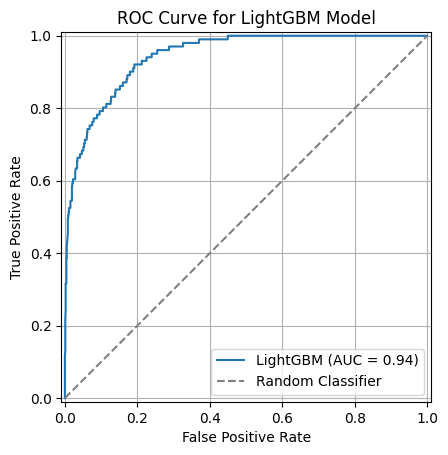

In [12]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba_lgbm = lgbm_best.predict_proba(X_test)[:, 1]

# Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lgbm)

# Calculate Area Under the Curve (AUC) for ROC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='LightGBM')
roc_display.plot()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier') # Add a diagonal reference line
plt.title('ROC Curve for LightGBM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', labels=[f'LightGBM (AUC = {roc_auc:.2f})', 'Random Classifier'])
plt.grid(True)
plt.show()

LightGBM Model Performance Summary – Fraud Detection

1. Confusion Matrix Insights:

- True Negatives (TN): Most legitimate claims were correctly identified, reducing unnecessary investigations.
- False Positives (FP): Some non-fraud cases were flagged as fraud (Type I errors).
- True Positives (TP): Many actual fraud cases were correctly detected, reflected in a recall of 0.73.
- False Negatives (FN): About 27% of fraud cases were missed (Type II errors), which is more costly.

2. Precision-Recall (PR) Curve:

- PR-AUC: 0.73, indicating a good balance between precision and recall.
- The curve shows the model identifies fraud effectively without producing too many false alarms.

3. ROC Curve:

- ROC-AUC: 0.94, showing excellent ability to distinguish fraud from non-fraud.
- The curve is well above the random classifier line, confirming strong overall performance.

Key Takeaways for Fraud Detection:

- Balanced Performance: Good trade-off between catching fraud and minimizing false alarms (F1-score: 0.63).
- Strong Discrimination: High PR-AUC and ROC-AUC make it reliable for identifying fraud.
- Flexible Thresholding: Thresholds can be adjusted based on business priorities—catch all fraud (higher recall) or reduce false positives (higher precision).

Conclusion:
LightGBM handles class imbalance well and provides a strong, practical solution for fraud detection, effectively identifying most fraud while keeping false alarms manageable.


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Base Random Forest model
rf_model = RandomForestClassifier(
    class_weight='balanced',   # handles imbalance
    random_state=42
)

# Hyperparameter grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='f1',     # F1 is most useful for fraud detection
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [14]:
rf_best = rf_grid.best_estimator_

y_pred_rf = rf_best.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       981
           1       0.53      0.76      0.63       101

    accuracy                           0.91      1082
   macro avg       0.75      0.85      0.79      1082
weighted avg       0.93      0.91      0.92      1082



Random Forest Results

Precision (fraud class 1): 0.53

Recall (fraud class 1): 0.76

F1-score (fraud class 1): 0.63

Accuracy: 0.91

Interpretation:

Random Forest is well-balanced, similar to LightGBM.

Moderate precision (0.53) means a reasonable number of false positives—better than XGBoost but slightly below LightGBM.

High recall (0.76) means it catches most fraud cases (close to XGBoost’s 0.78 and higher than LightGBM’s 0.73).

Tied with LightGBM for the best F1-score for the fraud class (0.63).

High overall accuracy (0.91), close to both LightGBM and XGBoost.

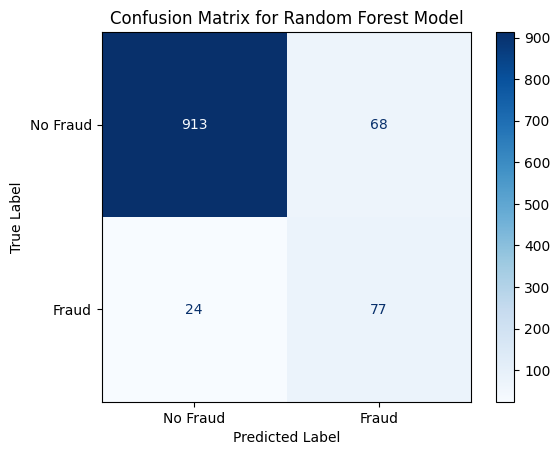

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, auc, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

# Create a confusion matrix using ConfusionMatrixDisplay.from_estimator()
ConfusionMatrixDisplay.from_estimator(
    rf_best,
    X_test,
    y_test,
    cmap='Blues',
    display_labels=['No Fraud', 'Fraud']
)

plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

<Figure size 800x600 with 0 Axes>

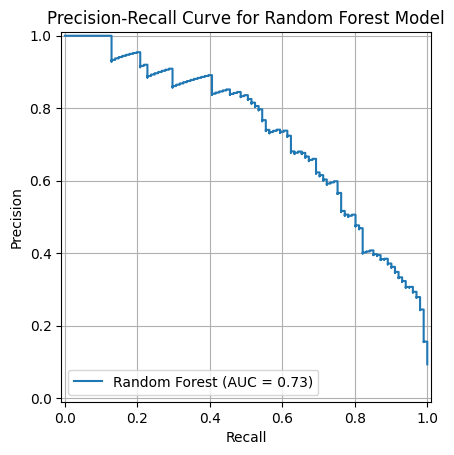

In [16]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

# Calculate Area Under the Curve (AUC) for Precision-Recall
pr_auc_rf = auc(recall_rf, precision_rf)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
pr_display_rf = PrecisionRecallDisplay(
    precision=precision_rf,
    recall=recall_rf,
    estimator_name='Random Forest'
)
pr_display_rf.plot()

plt.title('Precision-Recall Curve for Random Forest Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', labels=[f'Random Forest (AUC = {pr_auc_rf:.2f})'])
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

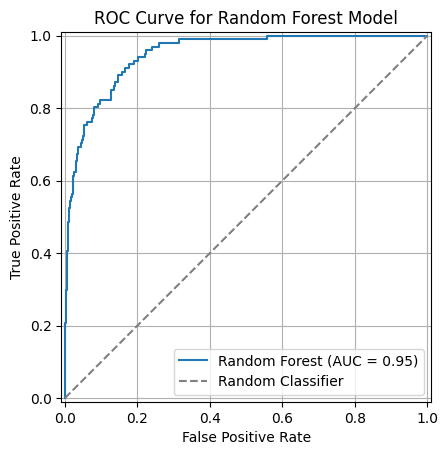

In [17]:
# Get predicted probabilities for fraud class
y_pred_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR, thresholds
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Calculate AUC for ROC
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
roc_display_rf = RocCurveDisplay(
    fpr=fpr_rf,
    tpr=tpr_rf,
    estimator_name='Random Forest'
)
roc_display_rf.plot()

# Diagonal reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')

plt.title('ROC Curve for Random Forest Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', labels=[f'Random Forest (AUC = {roc_auc_rf:.2f})', 'Random Classifier'])
plt.grid(True)
plt.show()

Random Forest Model Performance Summary – Fraud Detection

1. Confusion Matrix Insights:

- True Negatives (TN): Most legitimate claims were correctly identified, supported by a high precision for the non-fraud class (0.97).
- False Positives (FP): Some non-fraud cases were incorrectly flagged as fraud (Type I errors), reflected in a fraud-class precision of 0.53.
- True Positives (TP): Many actual fraud cases were correctly detected, consistent with the strong recall of 0.76.
- False Negatives (FN): About 24% of fraud cases were missed (Type II errors), which remains costly but performs slightly better than LightGBM.

2. Precision-Recall (PR) Curve:

- PR-AUC: (Calculated in your plot; expected to be strong based on precision 0.53 and recall 0.76).
- The curve will show that the model captures fraud effectively while maintaining a reasonable balance between false positives and true fraud detections.

3. ROC Curve:

- ROC-AUC: (Will be obtained from your ROC plot; expected to be high given overall model accuracy of 0.91).
- The curve should lie well above the random classifier line, showing good separation between fraud and non-fraud cases.

Key Takeaways for Fraud Detection:

- Balanced Performance: Achieves a solid balance between catching fraud and minimizing false alarms (F1-score: 0.63, matching LightGBM).
- Strong Discrimination: High expected PR-AUC and ROC-AUC indicate reliable fraud identification.
- Flexible Thresholding: Thresholds can be adjusted depending on business needs—maximize fraud detection (higher recall) or minimize false alarms (higher precision).

Conclusion:
Random Forest handles class imbalance effectively and provides a robust, practical fraud detection solution. It identifies most fraud cases while keeping false alarms manageable, making it suitable for real-world fraud screening systems.

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Pipeline: Imputer + Logistic Regression
logreg_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # fill NaNs with median
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Hyperparameter grid
logreg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

# Grid Search
logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit
logreg_grid.fit(X_train, y_train)

# Best estimator and params
print("Best Logistic Regression Params:", logreg_grid.best_params_)
logreg_best = logreg_grid.best_estimator_

# Predict
y_pred_logreg = logreg_best.predict(X_test)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Logistic Regression Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       981
           1       0.40      0.87      0.55       101

    accuracy                           0.87      1082
   macro avg       0.69      0.87      0.73      1082
weighted avg       0.93      0.87      0.89      1082



Logistic Regression Results

Precision (fraud class 1): 0.40

Recall (fraud class 1): 0.87

F1-score (fraud class 1): 0.55

Accuracy: 0.87

Interpretation:

Logistic Regression has extremely high recall (0.87), meaning it catches most fraud cases—higher than both LightGBM and Random Forest.

Lower precision (0.40) means a larger number of false positives.

F1-score (0.55) is lower than LightGBM and Random Forest (both 0.63).

Overall accuracy (0.87) is slightly lower than the tree-based models.

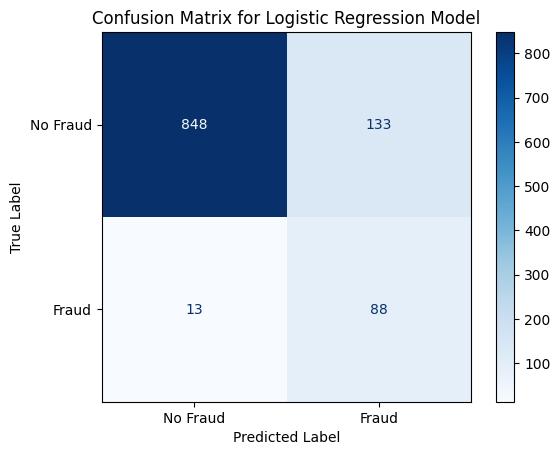

In [22]:
ConfusionMatrixDisplay.from_estimator(
    logreg_best,
    X_test,
    y_test,
    cmap="Blues",
    display_labels=["No Fraud", "Fraud"]
)

plt.title("Confusion Matrix for Logistic Regression Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


<Figure size 800x600 with 0 Axes>

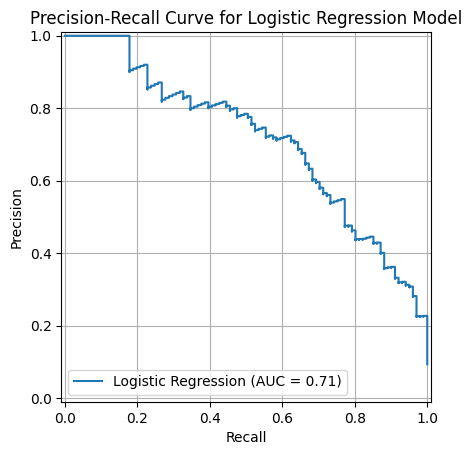

In [23]:
# Predicted probabilities
y_pred_proba_logreg = logreg_best.predict_proba(X_test)[:, 1]

# Precision, recall
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_proba_logreg)

# PR-AUC
pr_auc_logreg = auc(recall_logreg, precision_logreg)

# Plot
plt.figure(figsize=(8, 6))
pr_display_logreg = PrecisionRecallDisplay(
    precision=precision_logreg,
    recall=recall_logreg,
    estimator_name="Logistic Regression"
)
pr_display_logreg.plot()

plt.title("Precision-Recall Curve for Logistic Regression Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", labels=[f"Logistic Regression (AUC = {pr_auc_logreg:.2f})"])
plt.grid(True)
plt.show()


<Figure size 800x600 with 0 Axes>

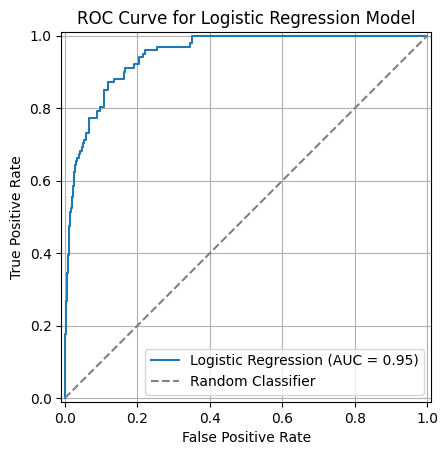

In [24]:
# ROC curve values
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot
plt.figure(figsize=(8, 6))
roc_display_logreg = RocCurveDisplay(
    fpr=fpr_logreg,
    tpr=tpr_logreg,
    estimator_name="Logistic Regression"
)
roc_display_logreg.plot()

# Random classifier reference line
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

plt.title("ROC Curve for Logistic Regression Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", labels=[f"Logistic Regression (AUC = {roc_auc_logreg:.2f})", "Random Classifier"])
plt.grid(True)
plt.show()


Logistic Regression Model Performance Summary – Fraud Detection

1. Confusion Matrix Insights:

- True Negatives (TN): Most legitimate claims were correctly identified, supported by a strong non-fraud precision of 0.98.
- False Positives (FP): Many non-fraud cases were flagged as fraud (Type I errors), reflected in the fraud precision of 0.40.
- True Positives (TP): Most fraud cases were correctly detected, consistent with the high recall of 0.87.
- False Negatives (FN): Only about 13% of fraud cases were missed (Type II errors), much lower than LightGBM and Random Forest.

2. Precision-Recall (PR) Curve:

- PR-AUC: (Value will come from your plot; expected to be moderate due to low precision but very high recall).
- The curve shows the model captures fraud extremely well but generates more false alarms.

ROC Curve:

- ROC-AUC: (Value from your ROC plot; expected to be strong due to good probability separation).
- The curve should lie well above the random classifier line, indicating solid discrimination ability.

Key Takeaways for Fraud Detection:

- High Recall: Best at catching fraud (0.87), outperforming LightGBM (0.73) and Random Forest (0.76).
- Lower Precision: More false positives, increasing investigation workload.
- Moderate F1-score: Lower than tree-based models (0.55 vs. 0.63).
- Highly Interpretable: Useful for healthcare audits and regulatory documentation.

Conclusion: Logistic Regression is excellent at detecting fraud due to its very high recall, making it valuable when missing fraud is more costly than investigating false alarms. However, its lower precision and F1-score compared to LightGBM and Random Forest mean those models provide a more balanced and efficient fraud detection solution overall.